In [47]:
#import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import sys
sys.path.append("..")  # Go up to amazon_usecase level
from utils.column_converter import convert_columns
import warnings
warnings.filterwarnings('ignore')


In [48]:
# Read TSV (specify separator as '\t')
df = pd.read_csv('../data/amazon_reviews_us_Books_v1_02.tsv', sep='\t', on_bad_lines='skip')

# Display the first 5 rows
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12076615,RQ58W7SMO911M,0385730586,122662979,Sisterhood of the Traveling Pants (Book 1),Books,4.0,2.0,3.0,N,N,this book was a great learning novel!,this boook was a great one that you could lear...,2005-10-14
1,US,12703090,RF6IUKMGL8SF,0811828964,56191234,The Bad Girl's Guide to Getting What You Want,Books,3.0,5.0,5.0,N,N,Fun Fluff,If you are looking for something to stimulate ...,2005-10-14
2,US,12257412,R1DOSHH6AI622S,1844161560,253182049,"Eisenhorn (A Warhammer 40,000 Omnibus)",Books,4.0,1.0,22.0,N,N,this isn't a review,never read it-a young relative idicated he lik...,2005-10-14
3,US,50732546,RATOTLA3OF70O,0373836635,348672532,Colby Conspiracy (Colby Agency),Books,5.0,2.0,2.0,N,N,fine author on her A-game,Though she is honored to be Chicago Woman of t...,2005-10-14
4,US,51964897,R1TNWRKIVHVYOV,0262181533,598678717,The Psychology of Proof: Deductive Reasoning i...,Books,4.0,0.0,2.0,N,N,Execellent cursor examination,Review based on a cursory examination by Unive...,2005-10-14


In [49]:
# Checking dtypes in case it needs to be converted
df.dtypes

marketplace           object
customer_id            int64
review_id             object
product_id            object
product_parent         int64
product_title         object
product_category      object
star_rating          float64
helpful_votes        float64
total_votes          float64
vine                  object
verified_purchase     object
review_headline       object
review_body           object
review_date           object
dtype: object

In [50]:
# Define conversion rules
conversion_rules = [
    (['review_date'], 'datetime')  # First convert these to numeric
]

# Apply conversions
df = convert_columns(df, conversion_rules)
# Filter the data from 2003 - 2005 as specified
df = df[(df['review_date'].dt.year >= 2003) & (df['review_date'].dt.year <= 2005)]


Converted 'review_date' from object to datetime.


## Basic Data Overview
1. Data looks fairly clean. Total reviews - 1.2million spread almost evenly across the three years (month on month).
2. No missing values in target column or the features
3. There is only one product category - Books and there's 370,978 unique products in the category
4. There are 10,403 duplicate reviews, 18,577 including original. We remove the origanls + duplicates if there's more than 3. Only keep the first if there's 3 or less dupes



In [51]:
print(f"Total reviews: {len(df):,}")
print(f"Columns: {df.columns.tolist()}")
print("\nMissing values:")
print(df.isnull().sum())
transactions_by_year = df['review_date'].dt.year.value_counts().sort_index()
print(f'Total transactions by year:{transactions_by_year}')
print(df.shape)
# Check for duplicate reviews
print(f"\nDuplicate reviews (same text): {df.duplicated(subset='review_body').sum()}")
print(f"\nDuplicate review ID (same text): {df.duplicated(subset='review_id').sum()}")




Total reviews: 1,286,157
Columns: ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

Missing values:
marketplace           0
customer_id           0
review_id             0
product_id            0
product_parent        0
product_title         0
product_category      0
star_rating           0
helpful_votes         0
total_votes           0
vine                  0
verified_purchase     0
review_headline      35
review_body           0
review_date           0
dtype: int64
Total transactions by year:review_date
2003    439976
2004    440365
2005    405816
Name: count, dtype: int64
(1286157, 15)

Duplicate reviews (same text): 10403

Duplicate review ID (same text): 0


#### Create target - Helpfulness ratio
1. Helpful ratio >70% - 65% of the reviews


In [52]:
# Create target column
df['helpfulness_ratio'] = np.where(
    df['total_votes'] > 0,
    df['helpful_votes'] / df['total_votes'],
    np.nan
)
print(df[df['helpfulness_ratio'] > 0.7].shape)
print(df[df['helpfulness_ratio'] <= 0.7].shape)

print('Percentage of helpful reviews:',750904/(750904+423965))
print('Percentage of unhelpful reviews:',423965/(750904+423965))


(750904, 16)
(423965, 16)
Percentage of helpful reviews: 0.6391384911849747
Percentage of unhelpful reviews: 0.3608615088150253


#### Analysing duplicates


In [53]:
# Get all duplicate review bodies (keeping first occurrence)
duplicates = df[df.duplicated(subset='review_body')].sort_values('review_body')

# Display duplicates with key columns
print(f"Found {len(duplicates):,} duplicate review texts (including originals)")
duplicates[['review_id', 'product_id', 'review_body', 'review_date', 'star_rating', 'helpfulness_ratio']].head(10)
# Are the same users posting identical reviews?
user_dupes = duplicates.groupby(['review_body', 'customer_id']).size().reset_index(name='count')
print(f"\nCases where same user posted identical reviews: {len(user_dupes[user_dupes['count'] > 1]):,}")

# Are the same products getting identical reviews from different users?
product_dupes = duplicates.groupby(['review_body', 'product_id']).size().reset_index(name='count')
print(f"Cases where same product got identical reviews from different users: {len(product_dupes[product_dupes['count'] > 1]):,}")
# Compare helpfulness of duplicates vs non-duplicates
dup_stats = duplicates['helpfulness_ratio'].describe()
non_dup_stats = df[~df.duplicated(subset='review_body', keep=False)]['helpfulness_ratio'].describe()

print("\nHelpfulness comparison:")
print(pd.DataFrame({'duplicates': dup_stats, 'non_duplicates': non_dup_stats}))
# # Plot duplicate frequency distribution
# plt.figure(figsize=(10, 5))
# dupe_counts['duplicate_count'].value_counts().sort_index().plot(kind='bar')
# plt.title('Frequency of Duplicate Review Counts')
# plt.xlabel('Number of Times Same Review Appears')
# plt.ylabel('Count')
# plt.show()

Found 10,403 duplicate review texts (including originals)

Cases where same user posted identical reviews: 999
Cases where same product got identical reviews from different users: 506

Helpfulness comparison:
        duplicates  non_duplicates
count  8244.000000    1.160041e+06
mean      0.648839    7.416257e-01
std       0.354143    2.894097e-01
min       0.000000    0.000000e+00
25%       0.388258    5.714286e-01
50%       0.750000    8.333333e-01
75%       1.000000    1.000000e+00
max       1.000000    1.000000e+00


#### Handling Duplicates

In [54]:

print(f"\nDuplicate reviews (same text): {df.duplicated(subset='review_body').sum()}")
print(f"\nDuplicate review ID (same text): {df.duplicated(subset='review_id').sum()}")
print(df.shape)
# Remove reviews that appear more than 3 times (adjust threshold as needed)
high_freq_dupes = df['review_body'].value_counts()[df['review_body'].value_counts() > 3].index
df_clean = df[~df['review_body'].isin(high_freq_dupes)]
# Keep only the first review when same user posts identical text
df_sorted = df_clean.sort_values(by='helpfulness_ratio', ascending=False)
# Step 2: Keep first occurrence of each duplicate review text
df_clean = df_sorted.drop_duplicates(subset='review_body', keep='first')
# Step 3: Sort back to original order (optional)
df = df_clean.sort_index()
# Check for duplicate reviews
print(f"\nDuplicate reviews (same text): {df.duplicated(subset='review_body').sum()}")
print(f"\nDuplicate review ID (same text): {df.duplicated(subset='review_id').sum()}")
print(df.shape)


Duplicate reviews (same text): 10403

Duplicate review ID (same text): 0
(1286157, 16)

Duplicate reviews (same text): 0

Duplicate review ID (same text): 0
(1275384, 16)


#### Plot for review count month on month (Checking for skewness)

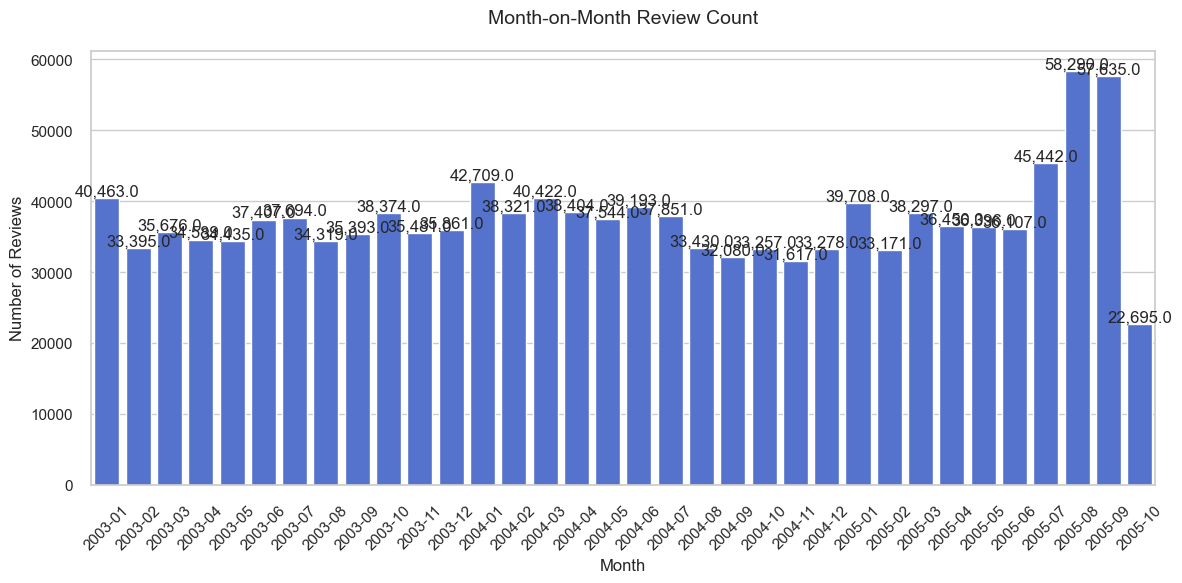

In [55]:
# Set style for better visuals
sns.set(style="whitegrid")
# Create a figure
plt.figure(figsize=(12, 6))
# Extract year-month from review_date for grouping
df['year_month'] = df['review_date'].dt.to_period('M').astype(str)
# Count reviews by month
monthly_reviews = df['year_month'].value_counts().sort_index()
ax = sns.barplot(x=monthly_reviews.index, y=monthly_reviews.values, color='royalblue')
plt.title('Month-on-Month Review Count', fontsize=14, pad=20)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Add value labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

#### Target column validation
1. We notice that about 27% of the reviews have just 1-3 total votes and also have a very high chance of them being helpful. As we are looking at just 2 years of data, that isnt enough time to filter on time period of these alerts. Hence we filter down the data to only consider data that have 3 or greater total votes

                count  mean_helpfulness  median_votes  pct_of_total
vote_category                                                      
0                   0               NaN           NaN      0.000000
1                   0               NaN           NaN      0.000000
2                   0               NaN           NaN      0.000000
3              102552          0.745284           3.0     10.950841
4               89489          0.745480           4.0      9.555931
5-9            290602          0.746132           7.0     31.031441
10-19          231735          0.745754          13.0     24.745429
20-49          160144          0.723447          28.0     17.100705
50-99           44248          0.675606          65.0      4.724948
100+            17706          0.703760         139.0      1.890705


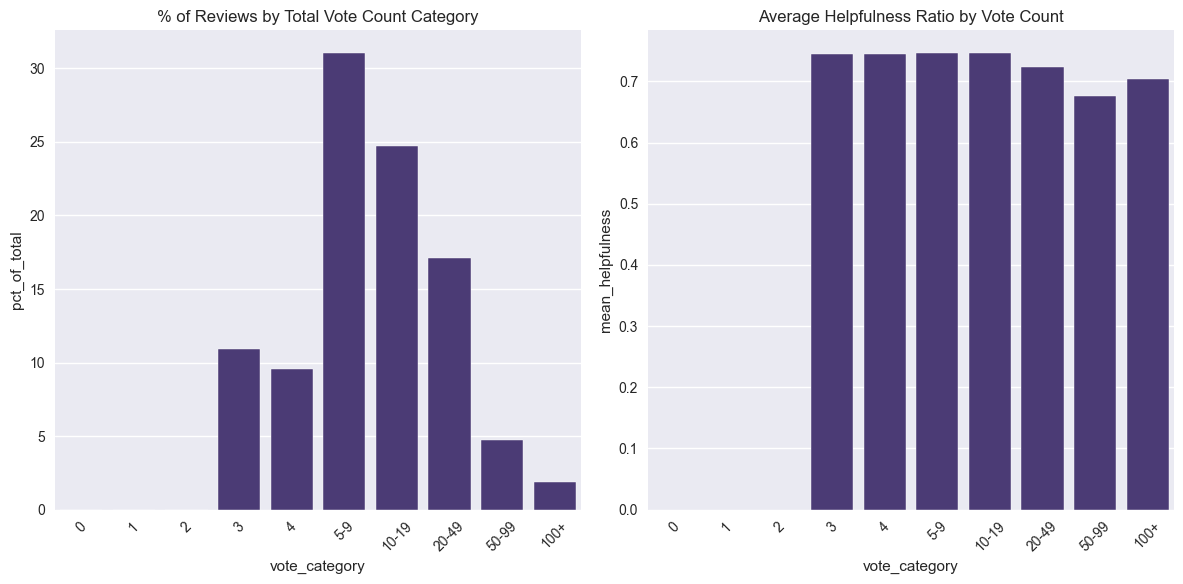

In [85]:
# TOTAL VOTES
# Categorize reviews by vote count ranges
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, np.inf]
labels = ['0', '1', '2', '3', '4', '5-9', '10-19', '20-49', '50-99', '100+']

df['vote_category'] = pd.cut(
    df['total_votes'],
    bins=bins,
    labels=labels,
    right=False
)

# Calculate statistics
vote_stats = df.groupby('vote_category').agg(
    count=('vote_category', 'size'),
    mean_helpfulness=('helpfulness_ratio', 'mean'),
    median_votes=('total_votes', 'median')
).assign(
    pct_of_total=lambda x: x['count']/len(df)*100
)

print(vote_stats)

# Visualize
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.barplot(data=vote_stats.reset_index(), x='vote_category', y='pct_of_total')
plt.title('% of Reviews by Total Vote Count Category')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(data=vote_stats.reset_index(), x='vote_category', y='mean_helpfulness')
plt.title('Average Helpfulness Ratio by Vote Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                count  mean_helpfulness  median_votes  pct_of_total
vote_category                                                      
0               13951          0.000000           0.0      1.489734
1               37263          0.241477           1.0      3.979066
2               72727          0.505198           2.0      7.766029
3              114750          0.759797           3.0     12.253384
4               92485          0.770437           4.0      9.875854
5-9            269985          0.785196           6.0     28.829890
10-19          189669          0.802691          13.0     20.253482
20-49          111114          0.827980          27.0     11.865120
50-99           24167          0.875923          64.0      2.580632
100+            10365          0.908102         146.0      1.106809


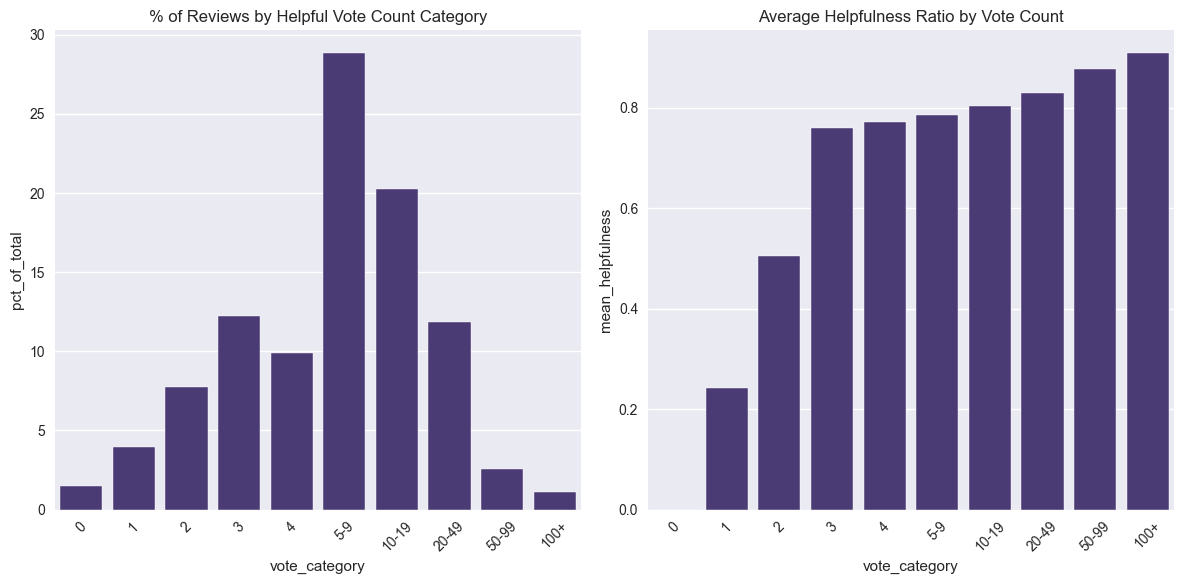

In [86]:
# Helpful votes
# Categorize reviews by vote count ranges
bins = [0, 1, 2, 3, 4, 5, 10, 20, 50, 100, np.inf]
labels = ['0', '1', '2', '3', '4', '5-9', '10-19', '20-49', '50-99', '100+']

df['vote_category'] = pd.cut(
    df['helpful_votes'],
    bins=bins,
    labels=labels,
    right=False
)

# Calculate statistics
vote_stats = df.groupby('vote_category').agg(
    count=('vote_category', 'size'),
    mean_helpfulness=('helpfulness_ratio', 'mean'),
    median_votes=('helpful_votes', 'median')
).assign(
    pct_of_total=lambda x: x['count']/len(df)*100
)

print(vote_stats)

# Visualize
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.barplot(data=vote_stats.reset_index(), x='vote_category', y='pct_of_total')
plt.title('% of Reviews by Helpful Vote Count Category')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
sns.barplot(data=vote_stats.reset_index(), x='vote_category', y='mean_helpfulness')
plt.title('Average Helpfulness Ratio by Vote Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filter data based on target column

In [58]:
print(df.shape)
df = df[df['total_votes']>=3]
print(df.shape)

(1275384, 18)
(936476, 18)


In [59]:
(1275384-936476)/1275384

0.26573016440538694

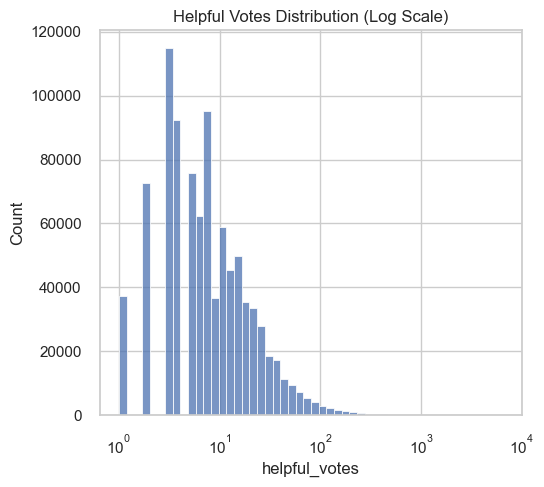

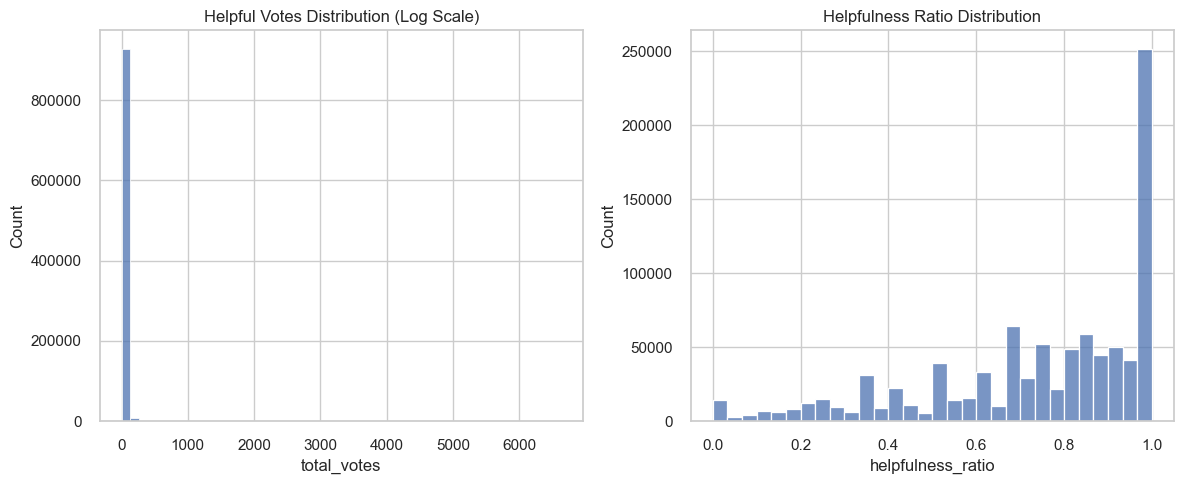

In [62]:
# Helpful votes distribution

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['helpful_votes'], bins=50, log_scale=True)
plt.title('Helpful Votes Distribution (Log Scale)')

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['total_votes'], bins=50, log_scale=True)
plt.title('Helpful Votes Distribution (Log Scale)')

plt.subplot(1,2,2)
sns.histplot(df['helpfulness_ratio'].dropna(), bins=30)
plt.title('Helpfulness Ratio Distribution')
plt.tight_layout()

# About 160,000 reviews have just 1 helpful vote (10^0)
# Only a handful reach 1,00+ votes (10^2-10^4). Most receive below 10 votes
# Ratio of 0 - not helpful, ratio - 1 - All votes are helpful
# Left tailed distribution of ratio suggests that more ofter than not, the reviews are positive. 0.7 seems to be a good starting point

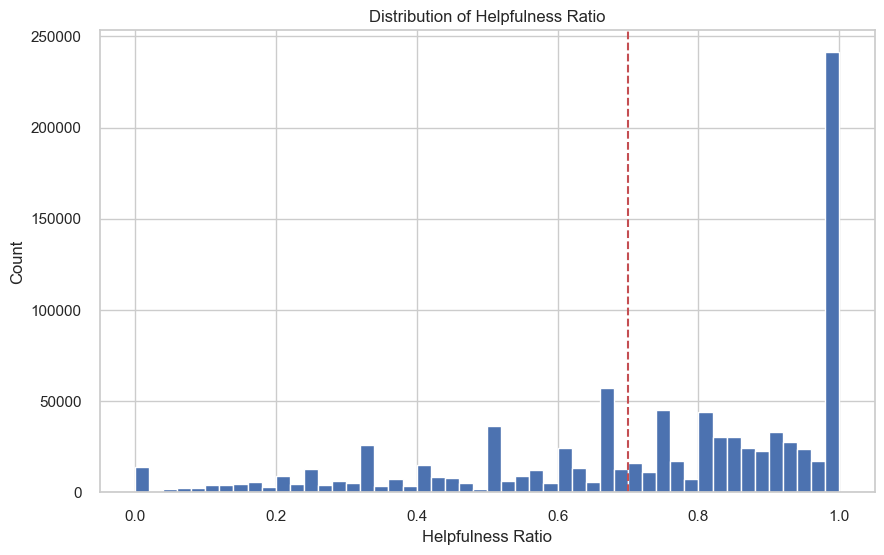

In [63]:
# 2. Distribution-Based Cutoff Analysis
plt.figure(figsize=(10, 6))
df['helpfulness_ratio'].hist(bins=50)
plt.axvline(x=0.7, color='r', linestyle='--')
plt.title('Distribution of Helpfulness Ratio')
plt.xlabel('Helpfulness Ratio')
plt.ylabel('Count')
plt.show()

In [64]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'helpfulness_ratio',
       'year_month', 'vote_category'],
      dtype='object')

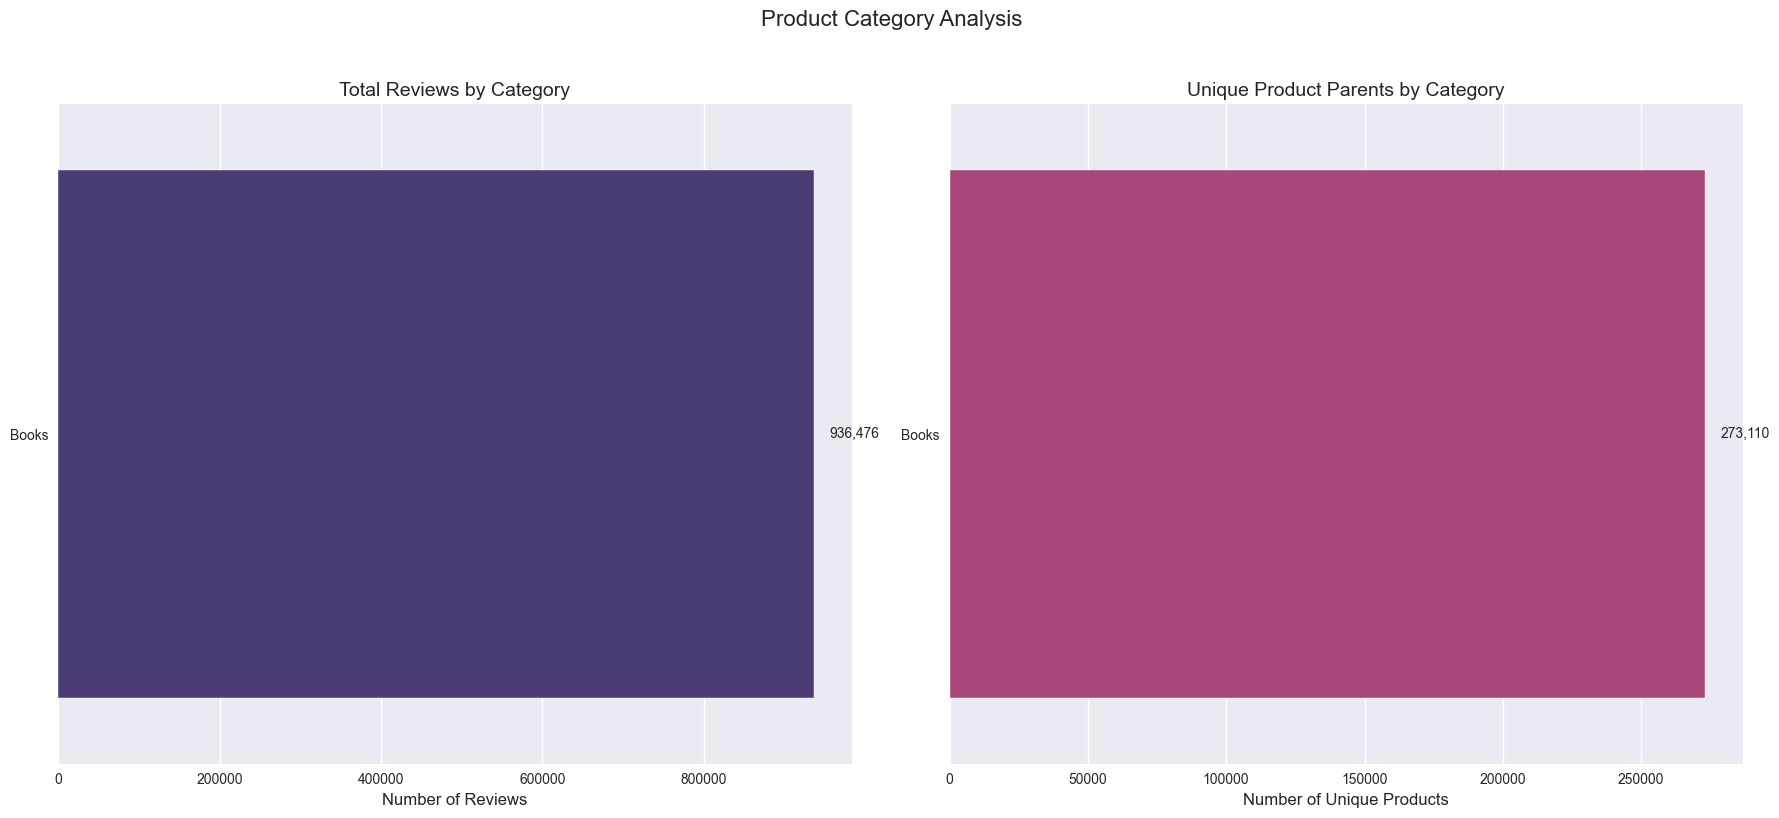


---------------- Analysis Summary ----------------
Total reviews: 936,476
Categories with null values: 0
Most reviewed category: Books (936,476 reviews)
Category with most unique products: Books (273,110 products)


In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure style
plt.style.use('seaborn')
sns.set_palette("viridis")

# Handle null categories
df['product_category'] = df['product_category'].fillna('Unknown')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Product Category Analysis', fontsize=16, y=1.02)

# 1. Total Reviews by Category
review_counts = df['product_category'].value_counts()
sns.barplot(x=review_counts.values, y=review_counts.index, ax=ax1, orient='h')
ax1.set_title('Total Reviews by Category', fontsize=14)
ax1.set_xlabel('Number of Reviews', fontsize=12)
ax1.set_ylabel('')

# Add value labels to first plot
for i, v in enumerate(review_counts.values):
    ax1.text(v + 0.02*v.max(), i, f'{v:,}', va='center', fontsize=10)

# 2. Unique Product Parents by Category
unique_parents = df.groupby('product_category')['product_parent'].nunique().sort_values(ascending=False)
sns.barplot(x=unique_parents.values, y=unique_parents.index, ax=ax2, orient='h', palette='magma')
ax2.set_title('Unique Product Parents by Category', fontsize=14)
ax2.set_xlabel('Number of Unique Products', fontsize=12)
ax2.set_ylabel('')

# Add value labels to second plot
for i, v in enumerate(unique_parents.values):
    ax2.text(v + 0.02*v.max(), i, f'{v:,}', va='center', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{' Analysis Summary ':-^50}")
print(f"Total reviews: {len(df):,}")
print(f"Categories with null values: {sum(df['product_category'] == 'Unknown'):,}")
print(f"Most reviewed category: {review_counts.idxmax()} ({review_counts.max():,} reviews)")
print(f"Category with most unique products: {unique_parents.idxmax()} ({unique_parents.max():,} products)")

## Univariate and Bivariate analysis
1. Star ratings mostly are 3 and above
2. Direct correlation between star rating and target.
3. Vine feature has very less cardidanilty spread and doesnt have a significant impact on target (inverse too)
4. Verified feature has 10% reviews from verified users and correlates positively to target

#### Star rating vs target

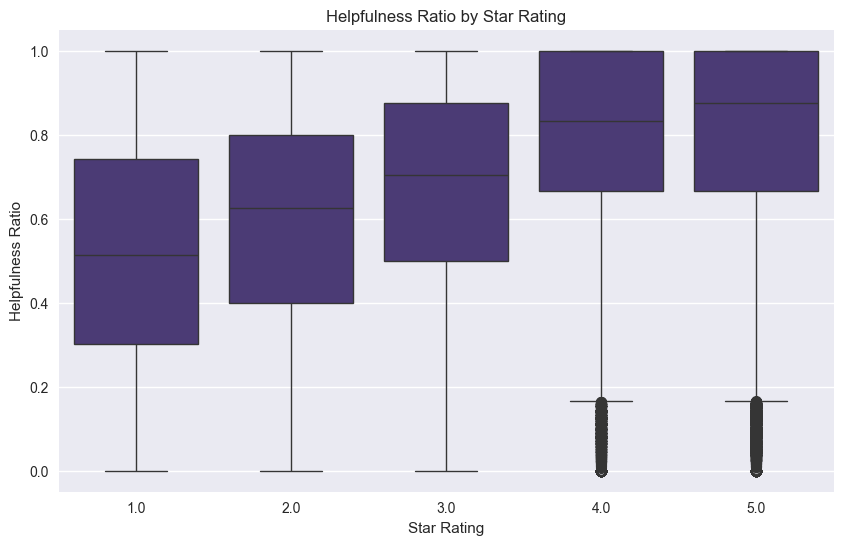

In [66]:
# Helpfulness ratio by star rating
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='star_rating', y='helpfulness_ratio')
plt.title("Helpfulness Ratio by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Helpfulness Ratio")
plt.show()

#### Vine program vs target, Verified purchase vs target

Distribution of Vine Status vine
N    99.999786
Y     0.000214
Name: proportion, dtype: float64


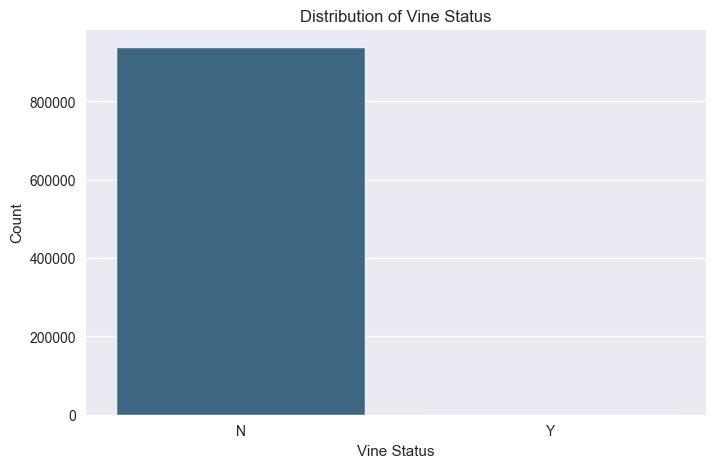

Distribution of Verified purchase verified_purchase
N    89.458566
Y    10.541434
Name: proportion, dtype: float64


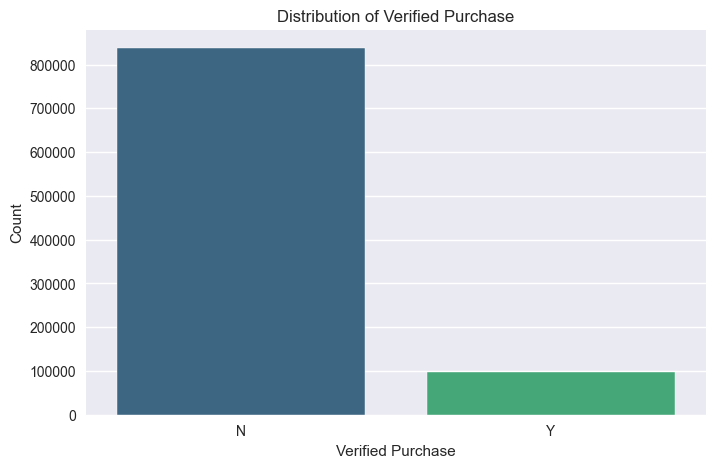

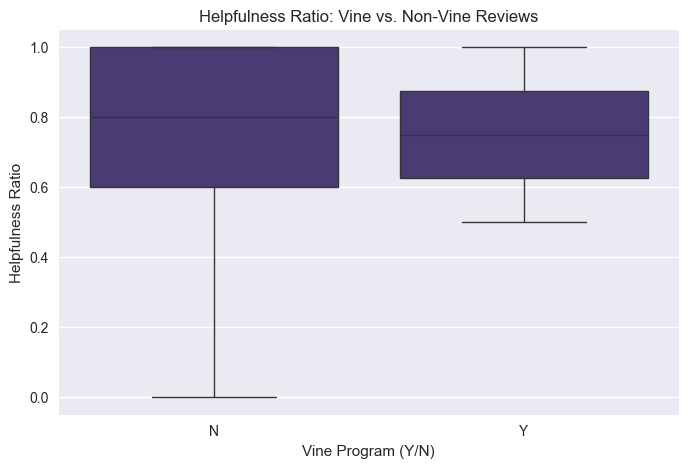

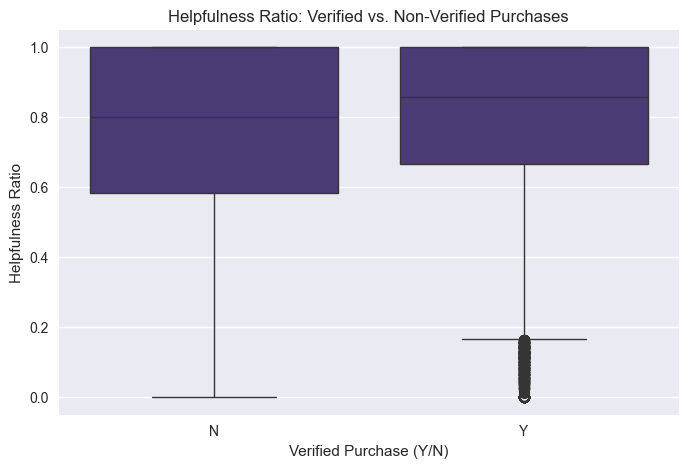

In [67]:
# Distribution of Vine Status
print(f"Distribution of Vine Status {df['vine'].value_counts(normalize=True) * 100}")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='vine', palette='viridis')
plt.title("Distribution of Vine Status")
plt.xlabel("Vine Status")
plt.ylabel("Count")
plt.show()
# Distribution of Verified purchase
print(f"Distribution of Verified purchase {df['verified_purchase'].value_counts(normalize=True) * 100}")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='verified_purchase', palette='viridis')
plt.title("Distribution of Verified Purchase")
plt.xlabel("Verified Purchase")
plt.ylabel("Count")
plt.show()

# Helpfulness ratio by Vine status
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='vine', y='helpfulness_ratio')
plt.title("Helpfulness Ratio: Vine vs. Non-Vine Reviews")
plt.xlabel("Vine Program (Y/N)")
plt.ylabel("Helpfulness Ratio")
plt.show()

# Helpfulness ratio by verified purchase
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='verified_purchase', y='helpfulness_ratio')
plt.title("Helpfulness Ratio: Verified vs. Non-Verified Purchases")
plt.xlabel("Verified Purchase (Y/N)")
plt.ylabel("Helpfulness Ratio")
plt.show()

#### Text based features
1. Does review body length impact helpfulness? 
2. Does review header lenght impact helpfulness?
3. Do certain keywords (Eg: "Excellent", "terrible") impact helpfulness? Perform Sentiment analysis

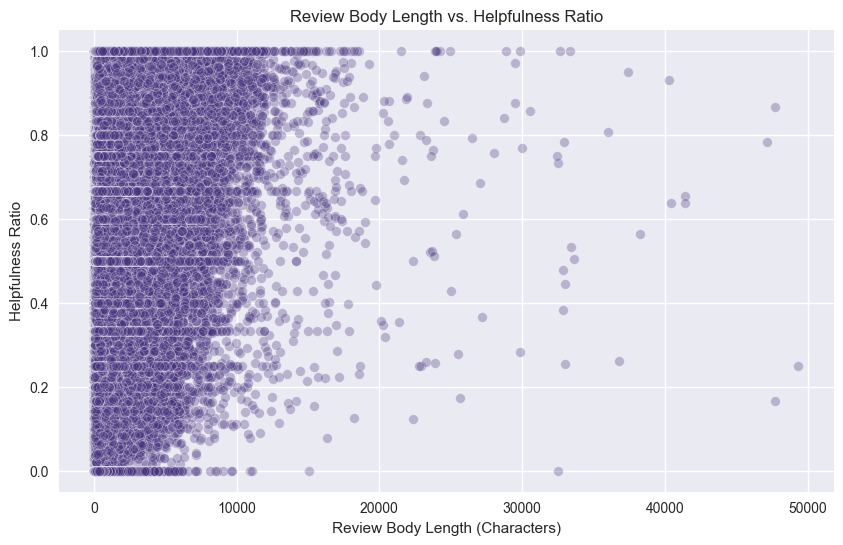

In [68]:
# Add review length features
df['headline_length'] = df['review_headline'].str.len()
df['body_length'] = df['review_body'].str.len()

# Plot review length vs. helpfulness
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='body_length', y='helpfulness_ratio', alpha=0.3)
plt.title("Review Body Length vs. Helpfulness Ratio")
plt.xlabel("Review Body Length (Characters)")
plt.ylabel("Helpfulness Ratio")
plt.show()

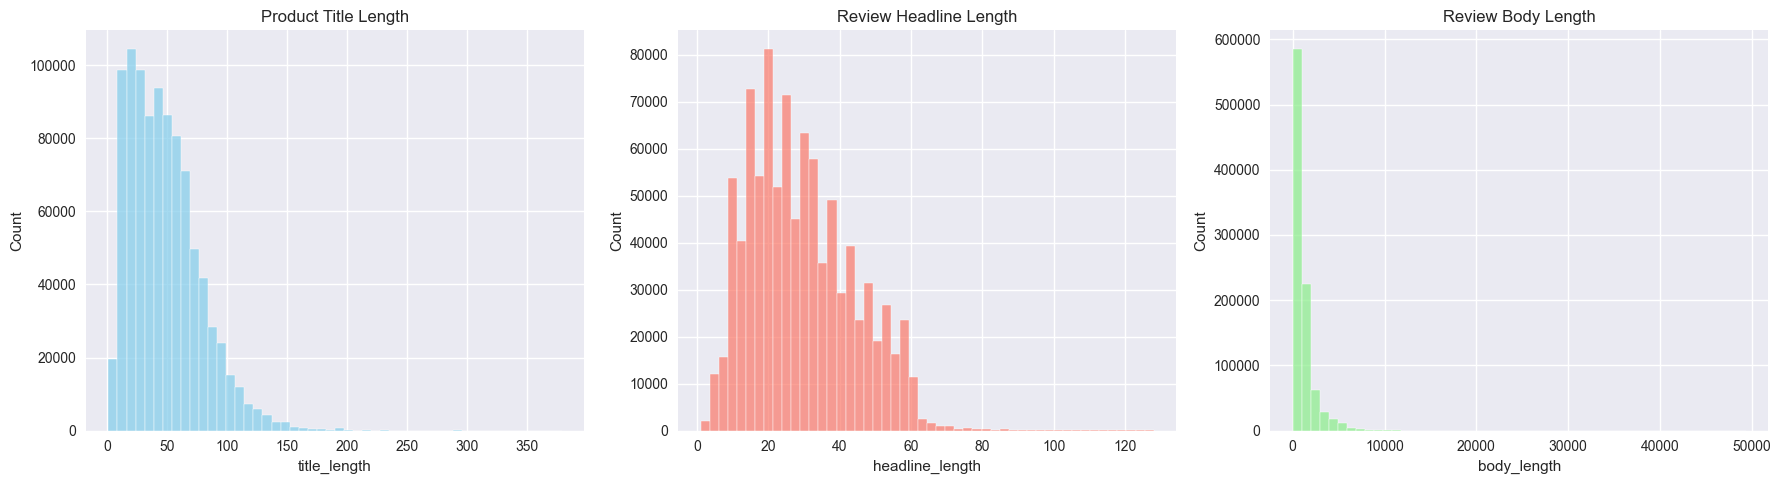

                   title_length  headline_length  body_length  \
title_length           1.000000         0.069585     0.004058   
headline_length        0.069585         1.000000     0.207805   
body_length            0.004058         0.207805     1.000000   
helpfulness_ratio      0.042989         0.117316     0.146603   

                   helpfulness_ratio  
title_length                0.042989  
headline_length             0.117316  
body_length                 0.146603  
helpfulness_ratio           1.000000  


In [69]:
# Calculate text length features
df['title_length'] = df['product_title'].str.len()
df['headline_length'] = df['review_headline'].str.len()
df['body_length'] = df['review_body'].str.len()

# Plot distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['title_length'], ax=axes[0], bins=50, color='skyblue')
sns.histplot(df['headline_length'], ax=axes[1], bins=50, color='salmon')
sns.histplot(df['body_length'], ax=axes[2], bins=50, color='lightgreen')
axes[0].set_title('Product Title Length')
axes[1].set_title('Review Headline Length')
axes[2].set_title('Review Body Length')
plt.tight_layout()
plt.show()

# Correlation with helpfulness
print(df[['title_length', 'headline_length', 'body_length', 'helpfulness_ratio']].corr())

##### Result: Raw lenght on texts dont seem to have high correlation. Lets look at more advanced processing

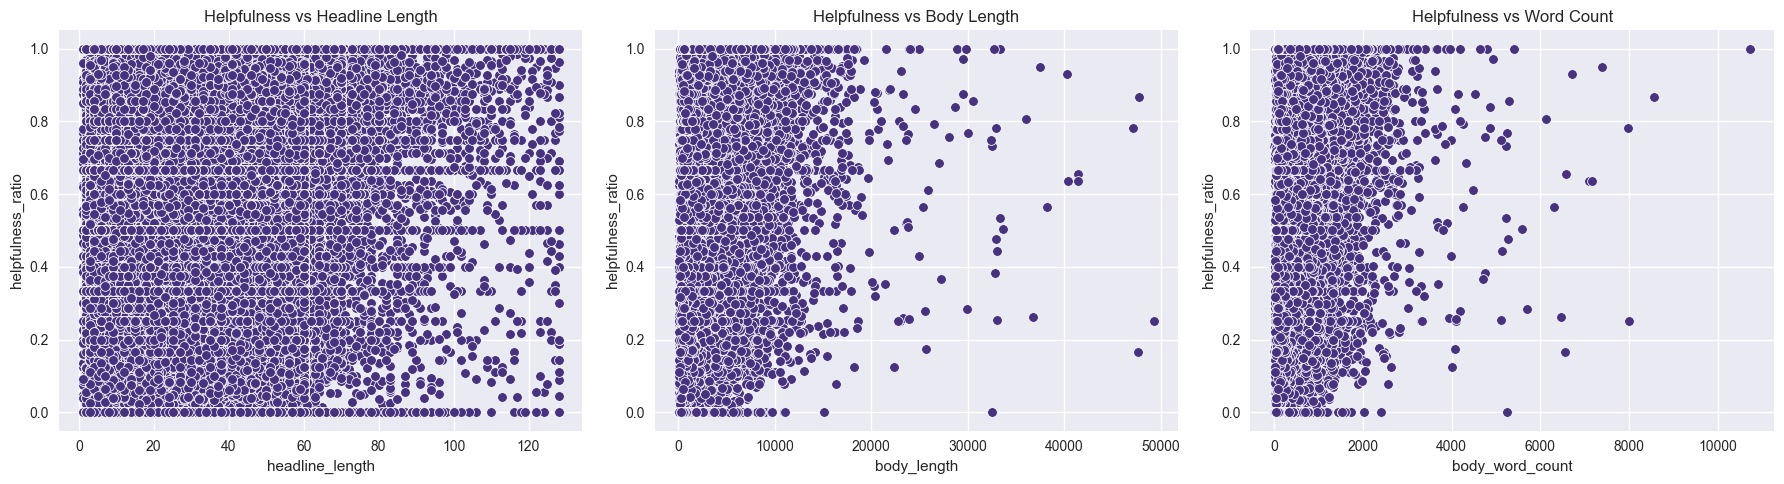

In [70]:
# Calculate readability scores (example using simple word count)
df['body_word_count'] = df['review_body'].str.split().str.len()
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Headline Length
sns.scatterplot(data=df, x='headline_length', y='helpfulness_ratio', ax=axes[0])
axes[0].set_title('Helpfulness vs Headline Length')

# Body Length
sns.scatterplot(data=df, x='body_length', y='helpfulness_ratio', ax=axes[1])
axes[1].set_title('Helpfulness vs Body Length')

# Word Count
sns.scatterplot(data=df, x='body_word_count', y='helpfulness_ratio', ax=axes[2])
axes[2].set_title('Helpfulness vs Word Count')

plt.tight_layout()
plt.show()

#### Sentiment Analysis

In [71]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud

# Polarity: -1.0 (most negative) to +1.0 (most positive)
# Subjectivity: 0.0 (factual) to 1.0 (highly opinionated)
# Using text blob as they work reasonably well for reviews.
# Calculate sentiment scores
df['polarity'] = df['review_body'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['review_body'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Correlation with helpfulness
print(df[['title_length', 'headline_length', 'body_length','polarity','subjectivity', 'helpfulness_ratio']].corr())

                   title_length  headline_length  body_length  polarity  \
title_length           1.000000         0.069585     0.004058  0.026489   
headline_length        0.069585         1.000000     0.207805 -0.029653   
body_length            0.004058         0.207805     1.000000 -0.160581   
polarity               0.026489        -0.029653    -0.160581  1.000000   
subjectivity          -0.056117        -0.056258    -0.107410  0.285455   
helpfulness_ratio      0.042989         0.117316     0.146603  0.109346   

                   subjectivity  helpfulness_ratio  
title_length          -0.056117           0.042989  
headline_length       -0.056258           0.117316  
body_length           -0.107410           0.146603  
polarity               0.285455           0.109346  
subjectivity           1.000000          -0.004839  
helpfulness_ratio     -0.004839           1.000000  


In [72]:
# Correlation check
print(df[['title_length', 'headline_length', 'body_length','polarity','subjectivity', 'helpfulness_ratio']].corr())

                   title_length  headline_length  body_length  polarity  \
title_length           1.000000         0.069585     0.004058  0.026489   
headline_length        0.069585         1.000000     0.207805 -0.029653   
body_length            0.004058         0.207805     1.000000 -0.160581   
polarity               0.026489        -0.029653    -0.160581  1.000000   
subjectivity          -0.056117        -0.056258    -0.107410  0.285455   
helpfulness_ratio      0.042989         0.117316     0.146603  0.109346   

                   subjectivity  helpfulness_ratio  
title_length          -0.056117           0.042989  
headline_length       -0.056258           0.117316  
body_length           -0.107410           0.146603  
polarity               0.285455           0.109346  
subjectivity           1.000000          -0.004839  
helpfulness_ratio     -0.004839           1.000000  


In [73]:
# df.to_csv('../data/amazon_reviews_added_ftrs.csv',index=False)

#### TF-IDF Analysis

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re
from bs4 import BeautifulSoup
import pandas as pd
import contractions

def clean_review_text(text):
    """
    Enhanced text cleaning for reviews with:
    - Better HTML cleaning
    - Contraction expansion
    - Misspelling correction (basic)
    - Punctuation normalization
    - Special character handling
    """
    if not isinstance(text, str):
        return ""
    
    # 1. Remove HTML tags and entities
    text = BeautifulSoup(text, "html.parser").get_text(separator=" ")
    
    # 2. Fix HTML artifacts and encoding issues
    text = re.sub(r'&[a-z]+;', '', text)
    text = re.sub(r'\\[a-z]+', '', text)
    
    # 3. Expand contractions (I'm -> I am, etc.)
    text = contractions.fix(text)
    
    # 4. Correct common misspellings (basic examples)
    common_misspellings = {
        r'\bu\b': 'you',
        r'\byuor\b': 'your',
        r'\byuo\b': 'you',
        r'\breccommend\b': 'recommend',
        r'\bimponrtance\b': 'importance',
        r'\bdiffernt\b': 'different',
        r'\bslihgtest\b': 'slightest',
        r'\bthrouh\b': 'through',
        r'\bboook\b': 'book',
        r'\bimmediatley\b': 'immediately'
    }
    for pattern, replacement in common_misspellings.items():
        text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
    # 5. Remove special characters except basic punctuation
    text = re.sub(r'[^\w\s.,!?\'"]', '', text)
    
    # 6. Normalize punctuation and spacing
    text = re.sub(r'\s+([.,!?])\s*', r'\1 ', text)  # Fix spacing around punctuation
    text = re.sub(r'\s{2,}', ' ', text)  # Remove extra spaces
    text = re.sub(r'([.,!?])\1+', r'\1', text)  # Remove duplicate punctuation
    
    # 7. Remove quote artifacts
    text = re.sub(r'\\"', '"', text)
    
    # 8. Final cleanup
    text = text.strip()
    text = text.lower()  # Optional: lowercase everything
    
    return text
# Apply cleaning to your DataFrame
df['cleaned_review'] = df['review_body'].apply(clean_review_text)
# Separate helpful vs unhelpful reviews
helpful = df[df['helpfulness_ratio'] > 0.7]['cleaned_review'].astype(str)
unhelpful = df[df['helpfulness_ratio'] < 0.3]['cleaned_review'].astype(str)

# Vectorize with minimum document frequency
# tfidf = TfidfVectorizer(
#     stop_words='english',
#     min_df=50,          # Only consider words appearing in at least 50 reviews
#     max_df=0.7          # Ignore words in more than 70% of reviews
# )
tfidf = TfidfVectorizer(
    stop_words='english',
    min_df=10,          # Reduced from 50 to capture more meaningful but less frequent terms
    max_df=0.6,         # Slightly more aggressive than 0.7 to filter very common terms
    dtype=np.float32
)

# Fit on all reviews to get consistent vocabulary
tfidf.fit(df['cleaned_review'].astype(str))

# Transform separately
helpful_matrix = tfidf.transform(helpful)
unhelpful_matrix = tfidf.transform(unhelpful)

# Calculate mean TF-IDF scores - Calculate distinctiveness scores
helpful_scores = np.asarray(helpful_matrix.mean(axis=0)).flatten()
unhelpful_scores = np.asarray(unhelpful_matrix.mean(axis=0)).flatten()

# Create comparison with discrimination score
word_comparison = pd.DataFrame({
    'word': tfidf.get_feature_names_out(),
    'helpful_score': helpful_scores,
    'unhelpful_score': unhelpful_scores
}).set_index('word')
# Filter out remaining artifacts
word_comparison = word_comparison[
    ~word_comparison.index.str.contains(r'^[^a-zA-Z]|^[a-z]{1,2}$')  # Remove short/non-word tokens
]

# Add discrimination metrics
word_comparison['helpfulness_discrimination'] = (
    word_comparison['helpful_score'] - word_comparison['unhelpful_score']
)

# Get most distinctive words
print("TOP HELPFUL WORDS:")
print(word_comparison.nlargest(10, 'helpful_score'))

print("\nTOP UNHELPFUL WORDS:")
print(word_comparison.nlargest(10, 'unhelpful_score'))
print("Words Most Predictive of Helpfulness:")
print(word_comparison.sort_values('helpfulness_discrimination', ascending=False).head(10))

print("\nWords Most Predictive of Unhelpfulness:")
print(word_comparison.sort_values('helpfulness_discrimination').head(10))

TOP HELPFUL WORDS:
         helpful_score  unhelpful_score  helpfulness_discrimination
word                                                               
read          0.023558         0.027602                   -0.004044
like          0.015240         0.017959                   -0.002718
books         0.014806         0.014179                    0.000627
great         0.014774         0.014090                    0.000683
story         0.014722         0.013000                    0.001721
just          0.014367         0.016562                   -0.002195
good          0.013740         0.018286                   -0.004546
life          0.013522         0.008061                    0.005461
time          0.012890         0.012074                    0.000816
reading       0.012036         0.012095                   -0.000059

TOP UNHELPFUL WORDS:
         helpful_score  unhelpful_score  helpfulness_discrimination
word                                                               
read   

In [75]:
# 1. First ensure word_comparison only contains words from TF-IDF vocabulary
vocab = set(tfidf.get_feature_names_out())
word_comparison = word_comparison[word_comparison.index.isin(vocab)]

# 2. Create weight vector aligned with TF-IDF features
word_weights = word_comparison['helpful_score'] - word_comparison['unhelpful_score']
word_weights = word_weights.reindex(tfidf.get_feature_names_out(), fill_value=0)

# 3. Calculate helpfulness signal
tfidf_features = tfidf.transform(df['cleaned_review'])
weighted_tfidf = tfidf_features.multiply(word_weights.values)
df['helpfulness_signal'] = np.array(weighted_tfidf.sum(axis=1)).flatten()

# Additional features
df['exclamation_count'] = df['cleaned_review'].str.count('!')
df['question_count'] = df['cleaned_review'].str.count('\?')
df['allcaps_count'] = df['cleaned_review'].str.findall(r'\b[A-Z]{2,}\b').str.len()
df['enhanced_helpfulness'] = (
    df['helpfulness_signal'] * 
    np.log1p(df['body_word_count']) * 
    (1 + df['polarity'])
)

# 4. Verify results
print("Helpfulness signal summary:")
print(df['helpfulness_signal'].describe())

Helpfulness signal summary:
count    936476.000000
mean          0.001585
std           0.001225
min          -0.007479
25%           0.000818
50%           0.001612
75%           0.002384
max           0.007870
Name: helpfulness_signal, dtype: float64


In [76]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'helpfulness_ratio',
       'year_month', 'vote_category', 'headline_length', 'body_length',
       'title_length', 'body_word_count', 'polarity', 'subjectivity',
       'cleaned_review', 'helpfulness_signal', 'exclamation_count',
       'question_count', 'allcaps_count', 'enhanced_helpfulness'],
      dtype='object')

In [80]:
print(df[['star_rating','title_length', 'headline_length', 'body_length','polarity','subjectivity','helpfulness_signal','exclamation_count', 'question_count',
       'allcaps_count', 'enhanced_helpfulness', 'helpfulness_ratio']].corr())

                      star_rating  title_length  headline_length  body_length  \
star_rating              1.000000      0.042689         0.070714     0.003269   
title_length             0.042689      1.000000         0.069585     0.004058   
headline_length          0.070714      0.069585         1.000000     0.207805   
body_length              0.003269      0.004058         0.207805     1.000000   
polarity                 0.377859      0.026489        -0.029653    -0.160581   
subjectivity             0.067924     -0.056117        -0.056258    -0.107410   
helpfulness_signal       0.345521      0.100580         0.178413     0.324148   
exclamation_count        0.055215     -0.005884         0.034052     0.129229   
question_count          -0.093798     -0.009112         0.055148     0.366347   
allcaps_count                 NaN           NaN              NaN          NaN   
enhanced_helpfulness     0.329580      0.087657         0.202061     0.460265   
helpfulness_ratio        0.3

#### Lexical feature eng

In [81]:
import re
# 1. Helpful/Unhelpful Keyword Flags
helpful_keywords = word_comparison.nlargest(50, 'helpful_score').index.tolist()
unhelpful_keywords = word_comparison.nlargest(50, 'unhelpful_score').index.tolist()
df['contains_helpful_kw'] = df['review_body'].str.contains(
    '|'.join(helpful_keywords), case=False
).astype(int)

df['contains_unhelpful_kw'] = df['review_body'].str.contains(
    '|'.join(unhelpful_keywords), case=False
).astype(int)

# 2. Keyword Ratio Feature
df['helpful_kw_ratio'] = (
    df['review_body'].str.count('|'.join(helpful_keywords), flags=re.IGNORECASE) / 
    np.maximum(df['body_word_count'], 1)  # Prevent divide by zero
)
df['helpful_kw_unique_count'] = df['cleaned_review'].apply(
    lambda x: len(set(str(x).lower().split()) & set(helpful_keywords)))  
df['kw_balance_score'] = (
    df['helpful_kw_ratio'] / 
    (df['cleaned_review'].str.count('|'.join(unhelpful_keywords), flags=re.IGNORECASE) + 0.01)
)

In [82]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'helpfulness_ratio',
       'year_month', 'vote_category', 'headline_length', 'body_length',
       'title_length', 'body_word_count', 'polarity', 'subjectivity',
       'cleaned_review', 'helpfulness_signal', 'exclamation_count',
       'question_count', 'allcaps_count', 'enhanced_helpfulness',
       'contains_helpful_kw', 'contains_unhelpful_kw', 'helpful_kw_ratio',
       'helpful_kw_unique_count', 'kw_balance_score'],
      dtype='object')

Bivariate analysis for created categorical features
1. 'contains_helpful_kw','contains_unhelpful_kw'
2. Results aren't great


Distribution of cont_helpful_kw contains_helpful_kw
1    99.047813
0     0.952187
Name: proportion, dtype: float64


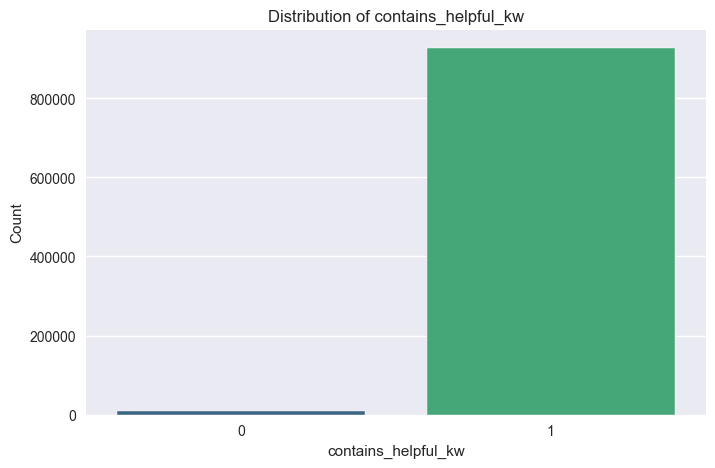

Distribution of contains_unhelpful_kw contains_unhelpful_kw
1    99.046318
0     0.953682
Name: proportion, dtype: float64


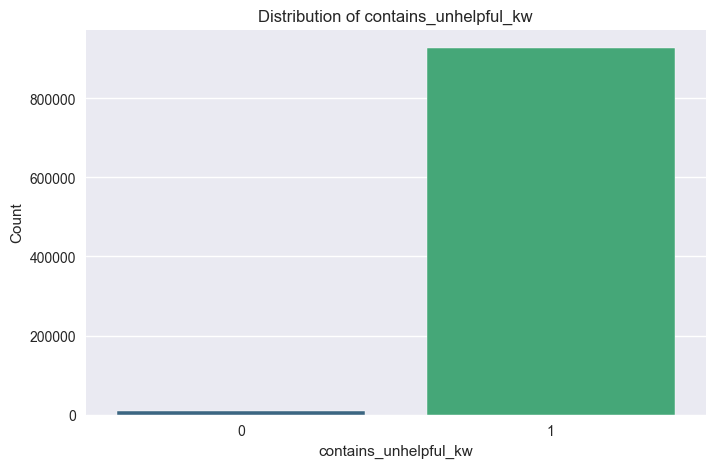

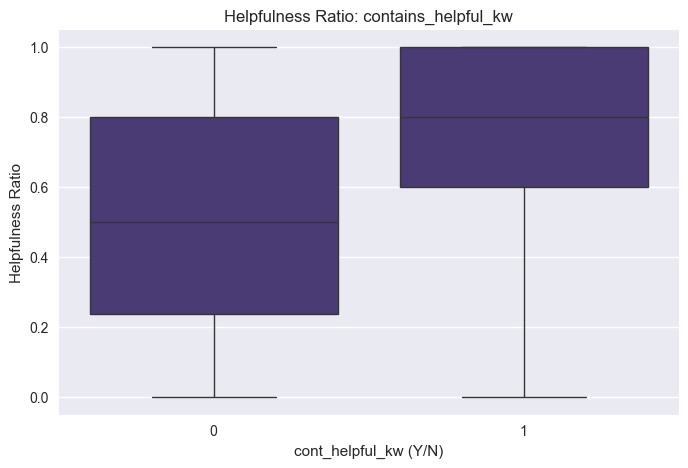

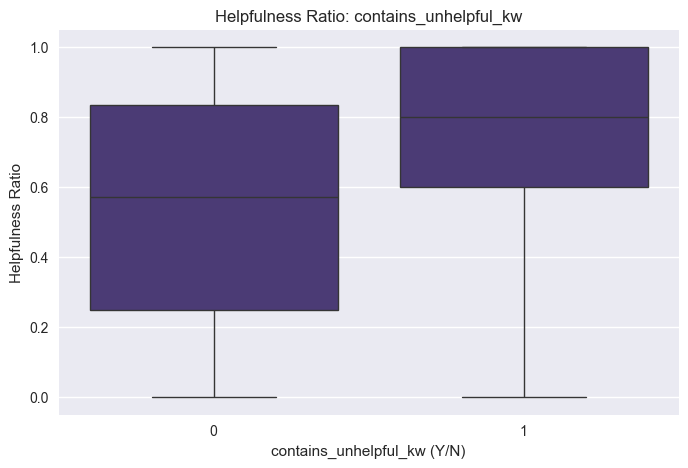

In [84]:
# Distribution of cont_helpful_kw
print(f"Distribution of cont_helpful_kw {df['contains_helpful_kw'].value_counts(normalize=True) * 100}")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='contains_helpful_kw', palette='viridis')
plt.title("Distribution of contains_helpful_kw")
plt.xlabel("contains_helpful_kw")
plt.ylabel("Count")
plt.show()
# Distribution of contains_unhelpful_kw
print(f"Distribution of contains_unhelpful_kw {df['contains_unhelpful_kw'].value_counts(normalize=True) * 100}")
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='contains_unhelpful_kw', palette='viridis')
plt.title("Distribution of contains_unhelpful_kw")
plt.xlabel("contains_unhelpful_kw")
plt.ylabel("Count")
plt.show()

# Helpfulness ratio by cont_helpful_kw
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='contains_helpful_kw', y='helpfulness_ratio')
plt.title("Helpfulness Ratio: contains_helpful_kw")
plt.xlabel("cont_helpful_kw (Y/N)")
plt.ylabel("Helpfulness Ratio")
plt.show()

# Helpfulness ratio by contains_unhelpful_kw
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='contains_unhelpful_kw', y='helpfulness_ratio')
plt.title("Helpfulness Ratio: contains_unhelpful_kw")
plt.xlabel("contains_unhelpful_kw (Y/N)")
plt.ylabel("Helpfulness Ratio")
plt.show()

#### Word cloud

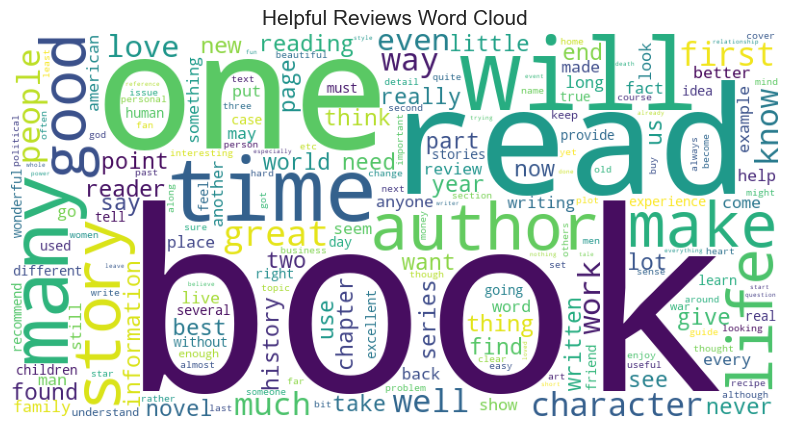

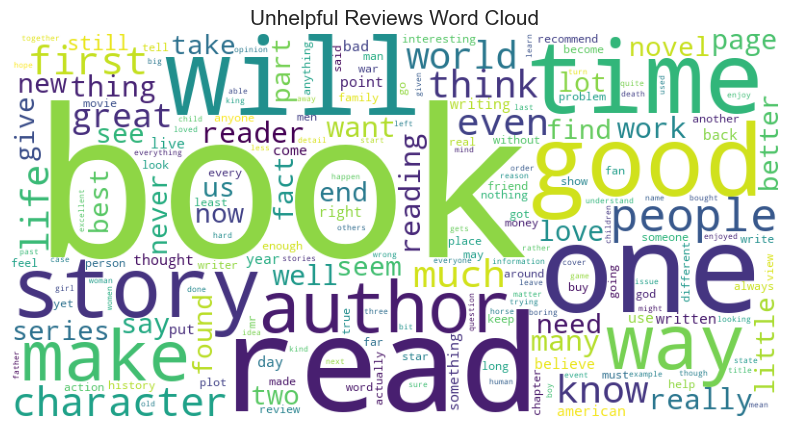

In [30]:
# Generate word clouds
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title, fontsize=15)
    plt.axis('off')

plot_wordcloud(' '.join(helpful.sample(1000)), 'Helpful Reviews Word Cloud')
plot_wordcloud(' '.join(unhelpful.sample(1000)), 'Unhelpful Reviews Word Cloud')
plt.show()

#### Temporal trends
1. Conistent but newer ratings seems to more helpful that older ones.
2. Last 2 months have been fairly low, which means that there might be lag of 2 months that help reviews reach the true potential of helpfulness


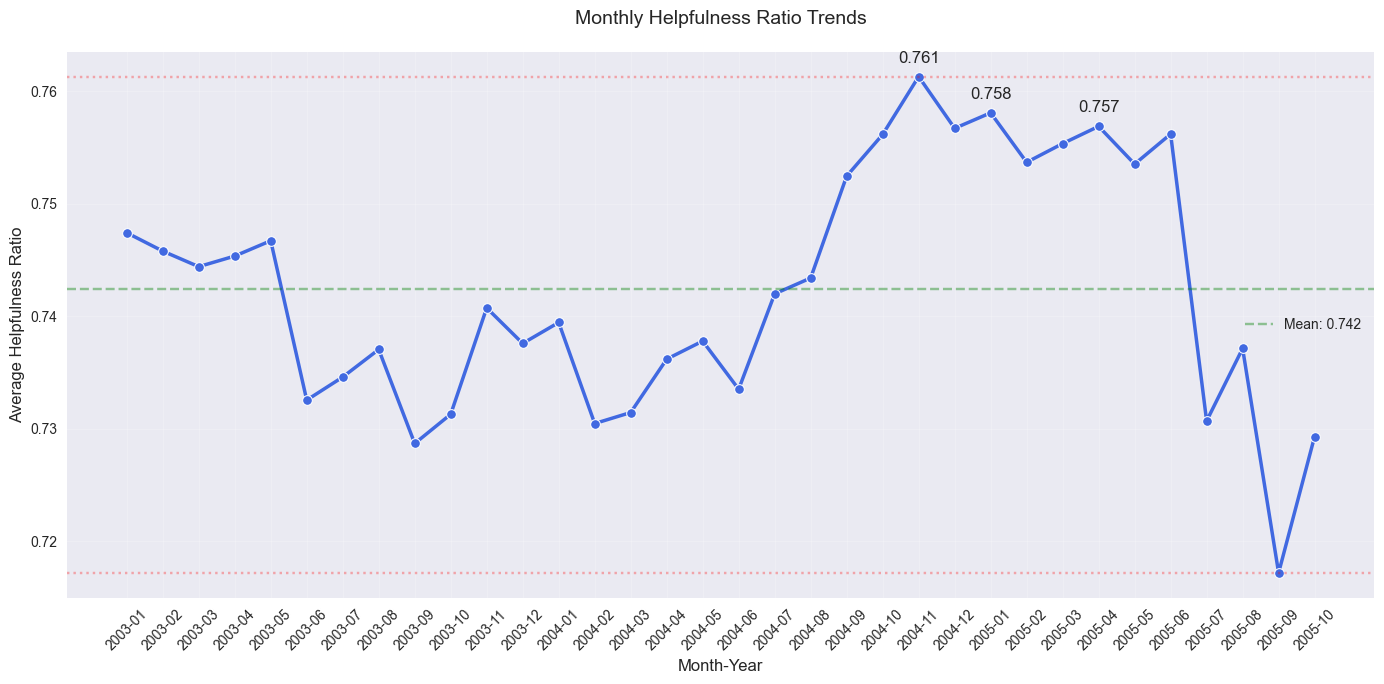

Time Period Covered: 2003-01 to 2005-10
Overall Mean Helpfulness: 0.742
Maximum Monthly Helpfulness: 0.761
Minimum Monthly Helpfulness: 0.717
Range: 0.044


In [91]:
# Calculate monthly averages
monthly_help = df.groupby('year_month')['helpfulness_ratio'].mean().reset_index()

# Create the plot
plt.figure(figsize=(14, 7))
ax = sns.lineplot(data=monthly_help, 
                 x='year_month', 
                 y='helpfulness_ratio',
                 marker='o',
                 linewidth=2.5,
                 color='royalblue')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Calculate reference values
max_val = monthly_help['helpfulness_ratio'].max()
min_val = monthly_help['helpfulness_ratio'].min()
mean_val = monthly_help['helpfulness_ratio'].mean()

# Add reference lines
ax.axhline(mean_val, color='green', linestyle='--', alpha=0.4, label=f'Mean: {mean_val:.3f}')
ax.axhline(max_val, color='red', linestyle=':', alpha=0.3)
ax.axhline(min_val, color='red', linestyle=':', alpha=0.3)

# Annotate peaks
for _, row in monthly_help.nlargest(3, 'helpfulness_ratio').iterrows():
    ax.annotate(f'{row["helpfulness_ratio"]:.3f}', 
                (row.name, row['helpfulness_ratio']),
                textcoords="offset points",
                xytext=(0,10), 
                ha='center')

plt.title('Monthly Helpfulness Ratio Trends', fontsize=14, pad=20)
plt.xlabel('Month-Year', fontsize=12)
plt.ylabel('Average Helpfulness Ratio', fontsize=12)
plt.grid(True, alpha=0.2)
plt.legend()
plt.tight_layout()
plt.show()

# Print statistics
print(f"Time Period Covered: {monthly_help['year_month'].iloc[0]} to {monthly_help['year_month'].iloc[-1]}")
print(f"Overall Mean Helpfulness: {mean_val:.3f}")
print(f"Maximum Monthly Helpfulness: {max_val:.3f}")
print(f"Minimum Monthly Helpfulness: {min_val:.3f}")
print(f"Range: {max_val - min_val:.3f}")

#### Correlation matrix

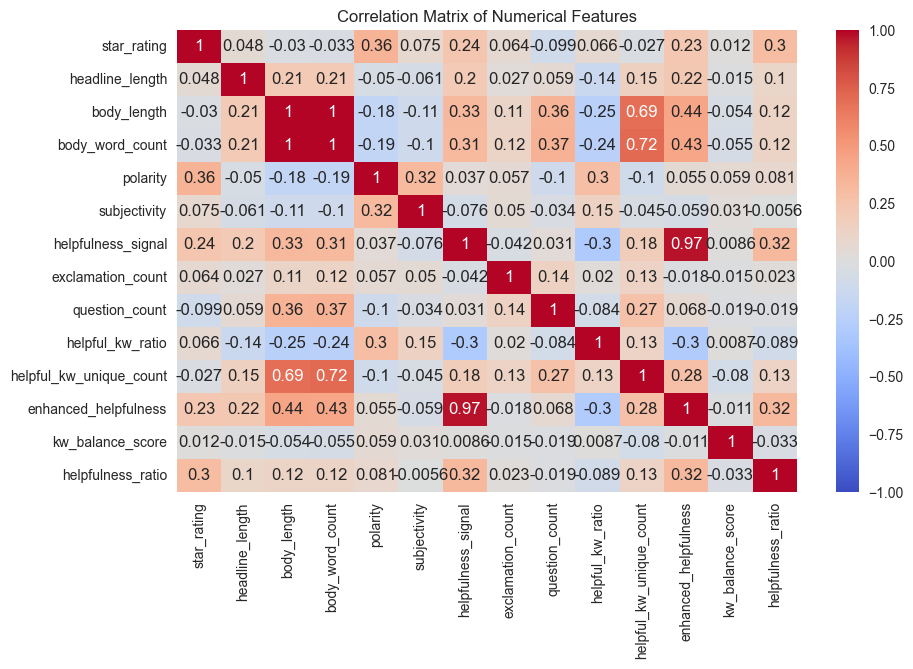

In [38]:
# Select numerical columns
numerical_cols = ['star_rating', 'headline_length', 'body_length','body_word_count', 'polarity', 'subjectivity'
                ,'helpfulness_signal', 'exclamation_count', 'question_count', 'helpful_kw_ratio', 'helpful_kw_unique_count',
       'enhanced_helpfulness','kw_balance_score','helpfulness_ratio']
corr_matrix = df[numerical_cols].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [32]:
df.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'helpfulness_ratio',
       'year_month', 'headline_length', 'body_length', 'title_length',
       'body_word_count', 'polarity', 'subjectivity', 'cleaned_review',
       'helpfulness_signal', 'exclamation_count', 'question_count',
       'allcaps_count', 'enhanced_helpfulness', 'contains_helpful_kw',
       'contains_unhelpful_kw', 'helpful_kw_ratio', 'helpful_kw_unique_count',
       'kw_balance_score'],
      dtype='object')

In [ ]:
# Identifying Valuable Reviews:
# High votes + high ratio: Consensus helpful (gold standard)
# Low votes + high ratio: Potentially hidden gems
# High votes + low ratio: Controversial but attention-grabbing